# Лабораторна робота №3
### Класифікація зображень згортковою нейронною мережею

### Мета: набути навички створення, навчання та тестування згорткових нейронних мереж типу VGG, використовуючи TensorFlow/Keras.

# Імпорт бібліотек та завантаження датасету
Використовується датасет CIFAR10

In [ ]:
#!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}

170498071/170498071 [==============================] - 4s 0us/step


# Створення VGG подібної згорткової нейронної мережі

## 1. Створення першого блоку ConvBlock

In [3]:
class ConvBlock(tf.keras.Model):
  def __init__ (
      self,
      filters: int,
      kernel_size: int,
      activation: str = "relu",
      name: str | None=None
  ):
    super().__init__(name=name)

    self.Conv1 = layers.Conv2D(
      filters = filters,
      kernel_size = kernel_size,
      activation = activation,
      padding='same'
    )
    self.Conv2 = layers.Conv2D(
      filters = filters,
      kernel_size = kernel_size,
      activation = activation,
      padding='same'
    )
    self.MaxPool = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')

  def call(self, inputs, training: bool):
    x = self.Conv1(inputs)
    x = self.Conv2(x)
    return self.MaxPool(x)

## 2. Створення блоку з повнозв'язними шарами

In [13]:
#added dense3 to check


class ClassificationHead(tf.keras.Model):
    def __init__(self, hidden_dim: list[int], n_classes: int, *args, **kwargs):
        super(ClassificationHead, self).__init__(*args, **kwargs)

        self.dense1 = layers.Dense(units=hidden_dim[0], activation='relu')
        self.dense2 = layers.Dense(units=hidden_dim[1], activation='relu')
        self.dense3 = layers.Dense(units=hidden_dim[2], activation='relu')
        self.out = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs, training: bool):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)

## 3. Складання цілої моделі зі створених раніше блоків

In [19]:
#reduced hidden_dim
#added more layers
class CNN_Classifier(tf.keras.Model):
    def __init__(self, n_classes: int, name: str | None = None):
        super().__init__(name=name)

        self.Conv1 = ConvBlock(filters=64, kernel_size=3)
        self.Conv2 = ConvBlock(filters=64, kernel_size=3)
        self.Conv3 = ConvBlock(filters=64, kernel_size=3)

        self.flatten = layers.Flatten()
        self.classification = ClassificationHead(hidden_dim=[128, 64, 32], n_classes=n_classes, name="head")

    def call(self, inputs, training: bool):
        x = self.Conv1(inputs)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.flatten(x)
        return self.classification(x)

# Тренування моделі

In [24]:
#changed opt to Lion
#changed back

model = CNN_Classifier(n_classes = len(id2class))
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [25]:
model.build((None, 32, 32, 3))
model.summary()

Model: "cnn__classifier_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_12 (ConvBlock)   multiple                  38720     
                                                                 
 conv_block_13 (ConvBlock)   multiple                  73856     
                                                                 
 conv_block_14 (ConvBlock)   multiple                  73856     
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 head (ClassificationHead)   multiple                  6900266   
                                                                 
Total params: 7086698 (27.03 MB)
Trainable params: 7086698 (27.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 9,
    batch_size = 128,
    validation_data = (x_test, y_test)
)

Epoch 1/9
391/391 [==============================] - 38s 91ms/step - loss: 1.5834 - accuracy: 0.4265 - val_loss: 1.2524 - val_accuracy: 0.5486
Epoch 2/9
391/391 [==============================] - 17s 44ms/step - loss: 1.1184 - accuracy: 0.6027 - val_loss: 1.0527 - val_accuracy: 0.6369
Epoch 3/9
391/391 [==============================] - 18s 46ms/step - loss: 0.9016 - accuracy: 0.6845 - val_loss: 0.8706 - val_accuracy: 0.6988
Epoch 4/9
391/391 [==============================] - 18s 45ms/step - loss: 0.7641 - accuracy: 0.7343 - val_loss: 0.8276 - val_accuracy: 0.7096
Epoch 5/9
391/391 [==============================] - 17s 44ms/step - loss: 0.6628 - accuracy: 0.7693 - val_loss: 0.8245 - val_accuracy: 0.7180
Epoch 6/9
391/391 [==============================] - 17s 44ms/step - loss: 0.5690 - accuracy: 0.8019 - val_loss: 0.7700 - val_accuracy: 0.7437
Epoch 7/9
391/391 [==============================] - 17s 44ms/step - loss: 0.4771 - accuracy: 0.8329 - val_loss: 0.8176 - val_accuracy: 0.7266

# Аналіз результатів
Побудова кривих навчання, класифікаційного звіту та хітмапи

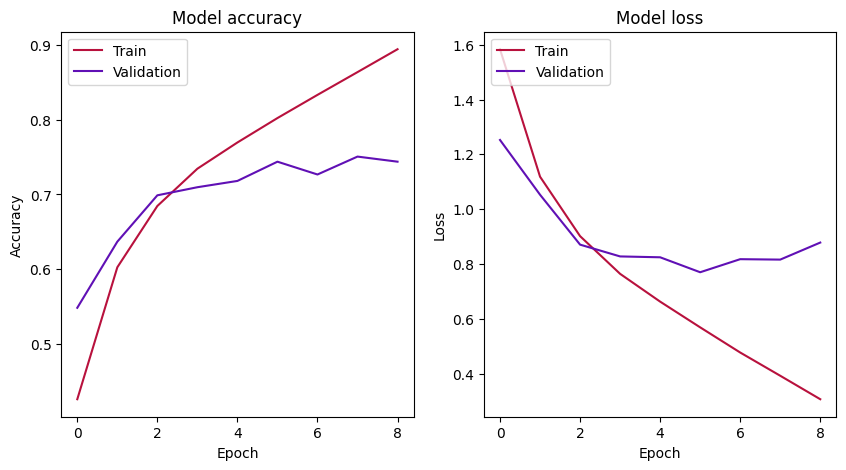

In [27]:
def plot_learning_curve(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(history)

In [31]:
y_pred = model.predict(x_test)
y_pred_uint8 = np.argmax(y_pred, axis=1).astype(np.uint8)
y_test_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

313/313 [==============================] - 1s 4ms/step


In [32]:
print("Classification Report:")
print(classification_report(y_test_unit8, y_pred_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1000
           1       0.86      0.85      0.85      1000
           2       0.73      0.58      0.64      1000
           3       0.51      0.60      0.55      1000
           4       0.71      0.67      0.69      1000
           5       0.65      0.69      0.67      1000
           6       0.81      0.76      0.78      1000
           7       0.74      0.84      0.79      1000
           8       0.87      0.84      0.85      1000
           9       0.83      0.83      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



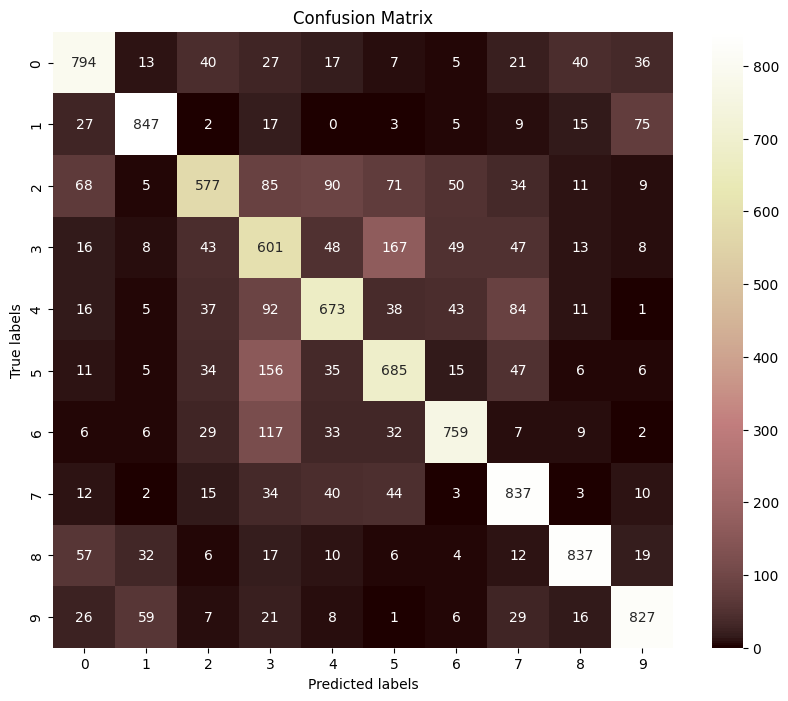

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [38]:
cm = confusion_matrix(y_test_unit8, y_pred_uint8)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

id2class

# Висновок
Було побудовано та натреновано власну модель за зразком VGG моделі для класифікації картинок на 10 класів, датасет CIFAR10. Модель було побудовано з двох частин: конвуляційна частина, яка складається з двох конвуляційних частин та макспулінгу, та класифікаційна частина, яка складається з трьох повнозв'язних шарів та вихідного шару. Між цими частинами знаходиться випрямляючий шар, що трансформує картинки у вектор.  

Модель показала найкращий результат 74%, що є посереднім результатом. Для тренування можелі знадобилося 9 епох. Модель легко перенавчається,тому було обрана саме така кількість.